# Emotional numbing in PTSD a look into a paradox

PTSD symptoms include (not only) symptoms of hyper arousal, anger, nightmares, problems with emotion regulation and... emotional numbing. </br>
While most symptoms point to over expression of emotions, emotional numbing states that there is low emotionality.

In a not really direct way, here, we will continue to explore the idea we proposed in the SIA paper.</br>
https://www.nature.com/articles/s41386-022-01405-2</br>
Mainly, reduced response to low valance/arousing stimuli and high response to higher valance stimuli.

In this experiment we will explore this by asking people with or without diagnosis of PTSD to rate pictures from known datasets (IAPS/NAPS).</br> 
Using the dataset reported valence rating as the X axis and participants rating as the y-axis, we will fit a 5 parameter logistic regression to the curve of participants and compare the parameters between the groups.

The formula we will use for the 5PL regression:
$$
y = d + \frac{a-d}{[1+(\frac{x}{c})^b]^g}
$$
a theoretical response at min</br>
b slope factor</br>
c mid range </br>
d theoretical response at max</br>
g asymmetrical factor</br>

Our main hypothesis is regarding b (Lower values of b point to a linear relation).</br>
We hypothesize that the PTSD group will show a larger b  compared with control.</br>
Secondary hypothesis include:</br>
1. b will be modulated by emotional numbing (PCL5)</br>
2. d will be modulated by depression/anhedonia score (PCL5/BDI)

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import pymc.sampling_jax as jx
import jax

import matplotlib.pyplot as ply
import seaborn as sns

/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Subject creation function

In [2]:
def add_sub(trials = 100, min_r = 0, max_r = 4, noise = .1, 
            slope=10, a1 = 1, a2 = 20, c_mu = 2, d1 = 10, d2 = 10, g_mu = 1,
            axis = False):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(a1, a2, 1)[0] # close to 0 but not 0.
    b = np.random.normal(slope, 2, 1)[0] # this is where the magic happens
    c = np.random.normal(c_mu, .5, 1)[0] # kind of average
    d = np.random.beta(d1, d2, 1)[0] # close to 0.5
    g = np.random.normal(g_mu, .2, 1)[0] # almost symetrical
    
    # the 5PL formula
    y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    
    # replace negative values with 0 (you cannot rate lower than 0)
    y = [0 if i < 0 else i for i in y]   

    df = pd.DataFrame({'x': x, 'y': y})
    if axis:
        return(x)
    return(df)

## Extract values from trace

In [3]:
def pred_trace(trace, single = True):
    a5 = az.summary(trace, var_names=['a'])[['mean']]
    b5 = az.summary(trace, var_names=['b'])[['mean']]
    c5 = az.summary(trace, var_names=['c'])[['mean']]
    d5 = az.summary(trace, var_names=['d'])[['mean']]
    g5 = az.summary(trace, var_names=['g'])[['mean']]

    if single:
        df = pd.DataFrame({'a': a5['mean'][0],
                           'b': b5['mean'][0],
                           'c': c5['mean'][0],
                           'd': d5['mean'][0],
                           'g': g5['mean'][0],
                           'x': x})
    else:
        df = pd.DataFrame({'a': np.mean(a5['mean']),
                           'b': np.mean(b5['mean']),
                           'c': np.mean(c5['mean']),
                           'd': np.mean(d5['mean']),
                           'g': np.mean(g5['mean']),
                           'x': x})

    df['y'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g
    
    return df

In [4]:
def pred_trace_group(trace, group = 'Control'):
    
    if group == 'Control':
        a5 = az.summary(trace, var_names=['aC'])[['mean']]
        b5 = az.summary(trace, var_names=['bC'])[['mean']]
        c5 = az.summary(trace, var_names=['cC'])[['mean']]
        d5 = az.summary(trace, var_names=['dC'])[['mean']]
        g5 = az.summary(trace, var_names=['gC'])[['mean']]
    else:
        a5 = az.summary(trace, var_names=['aP'])[['mean']]
        b5 = az.summary(trace, var_names=['bP'])[['mean']]
        c5 = az.summary(trace, var_names=['cP'])[['mean']]
        d5 = az.summary(trace, var_names=['dP'])[['mean']]
        g5 = az.summary(trace, var_names=['gP'])[['mean']]


    df = pd.DataFrame({'a': np.mean(a5['mean']),
                       'b': np.mean(b5['mean']),
                       'c': np.mean(c5['mean']),
                       'd': np.mean(d5['mean']),
                       'g': np.mean(g5['mean']),
                       'x': x})

    df['y'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g
    
    return df

## PYMC models

### Model for single subject

In [5]:
def pl5_single(df):
    
    with pm.Model() as five_PL:

        # hyper priors
        mu_b = pm.Normal('mu_b', 6, 3)
        mu_c = pm.Normal('mu_c', 3.5, 1)
        mu_g = pm.TruncatedNormal('mu_g', 1, .15, lower = .4)

        a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
        a2 = pm.Normal('a2', 20, 3)

        d1 = pm.TruncatedNormal('d1', 12, 2, lower = 0)
        d2 = pm.TruncatedNormal('d2', 8,  2, lower = 0)

        # priors
        a = pm.Beta('a',   a1,     a2)
        b = pm.Normal('b', mu_b,    2)
        c = pm.Normal('c', mu_c,    1)
        d = pm.Beta('d',   d1,     d2)
        g = pm.Normal('g', mu_g,  .15)

        eps = pm.Exponential('eps', 5)

        # model prediction using the 5PL regression    
        y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g

        # Likelihood (sampling distribution) of observations
        rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)

        trace = jx.sample_numpyro_nuts(tune = 3000, draws = 1000, target_accept=0.95)
        
    return trace

### Model for multiple subjects single group

In [6]:
def pl5_multi(df, idx, n_subs):

    with pm.Model() as five_PL_MS:

        # hyper priors
        mu_b = pm.Normal('mu_b', 6,    3)
        mu_c = pm.Normal('mu_c', 3.5,  1)
        mu_g = pm.TruncatedNormal('mu_g', 1, .15, lower = .4)

        a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
        a2 = pm.Normal('a2', 20, 3)

        d1 = pm.TruncatedNormal('d1', 12, 2, lower = 0)
        d2 = pm.TruncatedNormal('d2', 8,  2, lower = 0)

        # priors
        a = pm.Beta('a',   a1,    a2, shape = n_subs)
        b = pm.Normal('b', mu_b,   2, shape = n_subs)
        c = pm.Normal('c', mu_c,   1, shape = n_subs)
        d = pm.Beta('d',   d1,    d2, shape = n_subs)
        g = pm.Normal('g', mu_g, .15, shape = n_subs)


        eps = pm.Exponential('eps', 5)

        # model prediction using the 5PL regression    
        y_hat = d[idx] + (a[idx]-d[idx])/(1+(df['x'].values/c[idx])**b[idx])**g[idx]

        # Likelihood (sampling distribution) of observations
        rating = pm.Normal('rating',y_hat, eps, observed=df.y)

        trace = jx.sample_numpyro_nuts(tune = 3000, draws = 1000, target_accept=0.95)
        
    return trace

### Model for multiple subjects two group

In [7]:
def pl5_multi_groups(df1, df2, idx1, idx2, n_subs1, n_subs2 = 0):
    
    if n_subs2 == 0:
        n_subs2 = n_subs1

    with pm.Model() as five_PL_groups:


        # hyper prior per group
        mu_b = pm.Normal('mu_b', 6,    3, shape = 2)
        mu_c = pm.Normal('mu_c', 3.5,  1, shape = 2)
        mu_g = pm.TruncatedNormal('mu_g', 1, .15, lower = .4, shape = 2)

        a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0, shape = 2)
        a2 = pm.Normal('a2', 20, 3, shape = 2)

        d1 = pm.TruncatedNormal('d1', 12, 2, lower = 0, shape = 2)
        d2 = pm.TruncatedNormal('d2', 8,  2, lower = 0, shape = 2)

        # priors

        a_1 = pm.Beta('a_1',   a1[0],  a2[0], shape = n_subs1)
        b_1 = pm.Normal('b_1', mu_b[0], 2, shape = n_subs1)
        c_1 = pm.Normal('c_1', mu_c[0], 5, shape = n_subs1)
        d_1 = pm.Beta('d_1',   d1[0],  d2[0], shape = n_subs1)
        g_1 = pm.Normal('g_1', mu_g[0],.2, shape = n_subs1)

        a_2 = pm.Beta('a_2',   a1[1],  a2[1], shape = n_subs2)
        b_2 = pm.Normal('b_2', mu_b[1], 2, shape = n_subs2)
        c_2 = pm.Normal('c_2', mu_c[1], 5, shape = n_subs2)
        d_2 = pm.Beta('d_2',   d1[1],  d2[1], shape = n_subs2)
        g_2 = pm.Normal('g_2', mu_g[1],.2, shape = n_subs2)


        eps = pm.Exponential('eps', 5, shape = 2)

        # model prediction using the 5PL regression    
        y_hat1 = d_1[idx1] + (a_1[idx1]-d_1[idx1])/(1+(df1['x'].values/c_1[idx1])**b_1[idx1])**g_1[idx1]
        y_hat2 = d_2[idx2] + (a_2[idx2]-d_2[idx2])/(1+(df2['x'].values/c_2[idx2])**b_2[idx2])**g_2[idx2]

        # Likelihood (sampling distribution) of observations
        rating1 = pm.Normal('rating1',y_hat1, eps[0], observed=df1.y)
        rating2 = pm.Normal('rating2',y_hat2, eps[1], observed=df2.y)

        trace = jx.sample_numpyro_nuts(tune = 3000, draws = 1000, target_accept=0.95)
        
    return trace

## Single subject analysis

To see the model ability to fit a curve to simulate data, we will start with 1 subject with no noise.

<AxesSubplot:xlabel='x', ylabel='y'>

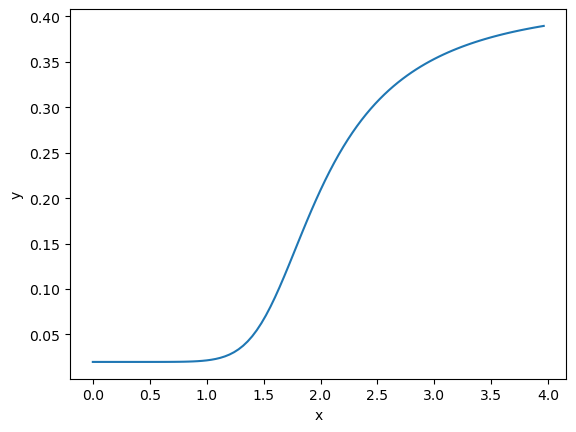

In [8]:
df = add_sub(noise = 0)   
x = add_sub(axis=True)

sns.lineplot(x='x',y='y',data=df)

In [9]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * df.x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_l = jx.sample_numpyro_nuts(tune = 3000, draws = 1000, target_accept=0.95)

Compiling...
Compilation time =  0:00:11.805983
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:05.102808
Transforming variables...
Transformation time =  0:00:00.031826
Computing Log Likelihood...
Log Likelihood time =  0:00:00.449356


In [10]:
trace_PL5 = pl5_single(df)
trace_PL5.to_netcdf("traces/trace_PL5.nc")

Compiling...
Compilation time =  0:00:26.154342
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:05:08.186991
Transforming variables...
Transformation time =  0:00:00.122197
Computing Log Likelihood...
Log Likelihood time =  0:00:00.427247


'traces/trace_PL5.nc'

In [11]:
comp = az.compare({'Linear model': trace_l, '5PL model': trace_PL5}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
5PL model,0,1412.058253,4.596838,0.000000,1.000000e+00,0.114207,0.000000,False,log
Linear model,1,174.200499,2.327415,1237.857754,9.513315e-10,4.510795,4.481281,False,log


<AxesSubplot:xlabel='Log'>

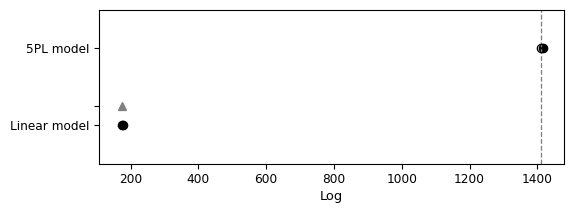

In [12]:
az.plot_compare(comp)

<AxesSubplot:xlabel='x', ylabel='y'>

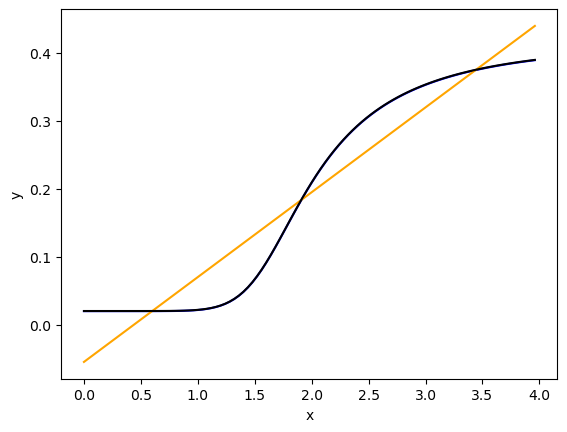

In [13]:
al = az.summary(trace_l, var_names=['a'])[['mean']]
bl = az.summary(trace_l, var_names=['b'])[['mean']]

df_l = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l['y'] = df_l.a + df_l.b * df_l.x

df_5 = pred_trace(trace_PL5)

sns.lineplot(x='x',y='y',data=df, color = 'blue')
sns.lineplot(x='x',y='y',data=df_l, color = 'orange')
sns.lineplot(x='x',y='y',data=df_5, color = 'black')

### single subject no noise 

Not suprisngly the 5PL regression out preformed the linear model.</br>
The model was able to fit perfectly to the curve, no divergencies.

## Single subject with noise

In the next test we will add noise (.05).

<AxesSubplot:xlabel='x', ylabel='y'>

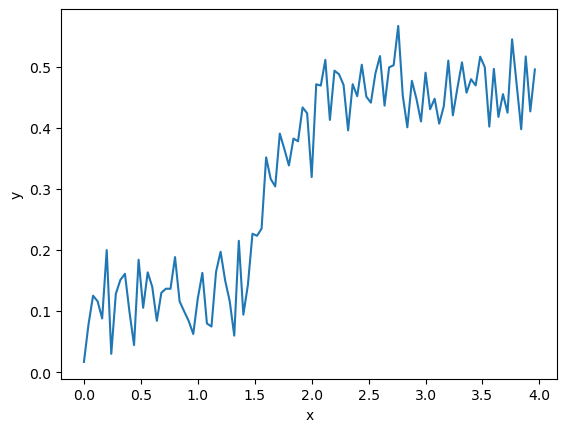

In [14]:
df = add_sub(noise=.05)

sns.lineplot(x='x',y='y',data=df)

In [15]:
trace_5_n = pl5_single(df)
trace_5_n.to_netcdf("traces/trace_5_n.nc")

Compiling...
Compilation time =  0:00:04.706530
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:14.095186
Transforming variables...
Transformation time =  0:00:00.027959
Computing Log Likelihood...
Log Likelihood time =  0:00:00.284143


'traces/trace_5_n.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

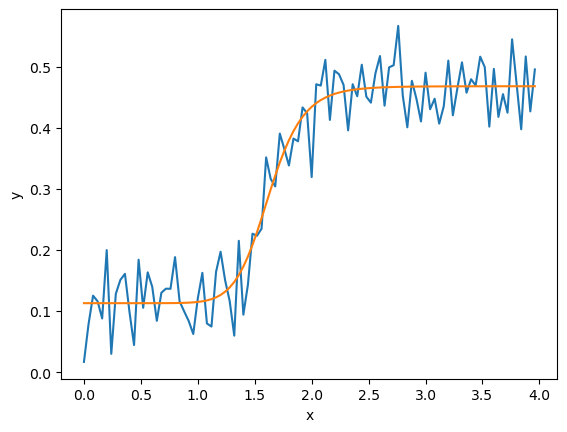

In [16]:
df_5_n = pred_trace(trace_5_n)

sns.lineplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

### Single subject expected noise

The curve fit nicely, no div. Model works. </br>
Just in case let's check a subject with a lot of noise (.1)

## Single subject excessive noise analysis

<AxesSubplot:xlabel='x', ylabel='y'>

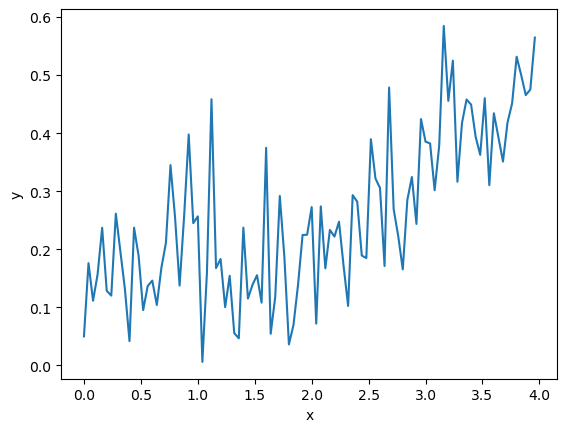

In [17]:
df = add_sub(noise = .1)   

sns.lineplot(x='x',y='y',data=df)

In [18]:
trace_5_mn = pl5_single(df)
trace_5_mn.to_netcdf("traces/trace_5_mn.nc")

Compiling...
Compilation time =  0:00:04.472639
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:17.423284
Transforming variables...
Transformation time =  0:00:00.027688
Computing Log Likelihood...
Log Likelihood time =  0:00:00.280074


'traces/trace_5_mn.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

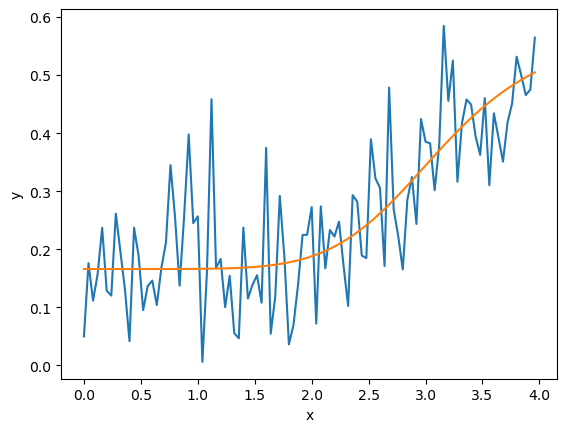

In [19]:
df_5_n = pred_trace(trace_5_mn)

sns.lineplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

### Single subject excessive noise

The model can handle this amount of noise! </br>
But can the model handle linear data? it is very possible that participant will rate the pictures linearly.

## Single subject linear data no noise

<AxesSubplot:xlabel='x', ylabel='y'>

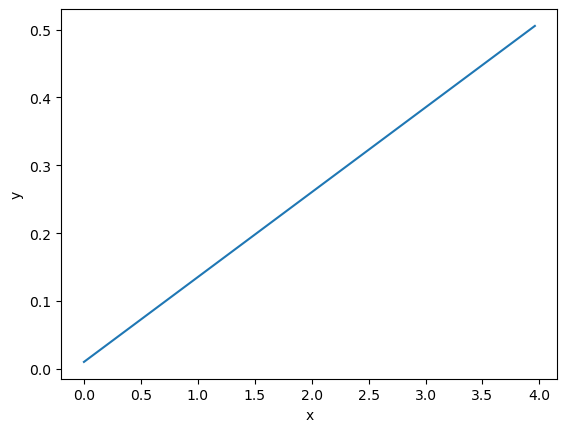

In [20]:
y = x/8 + np.random.normal(0,.1)**2
df = pd.DataFrame({'x':x, 'y':y})

sns.lineplot(x='x',y='y',data=df)

In [21]:
trace_5_lin = pl5_single(df)
trace_5_lin.to_netcdf("traces/trace_5_lin.nc")

Compiling...
Compilation time =  0:00:04.737430
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:01:39.558464
Transforming variables...
Transformation time =  0:00:00.035887
Computing Log Likelihood...
Log Likelihood time =  0:00:00.292797


'traces/trace_5_lin.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

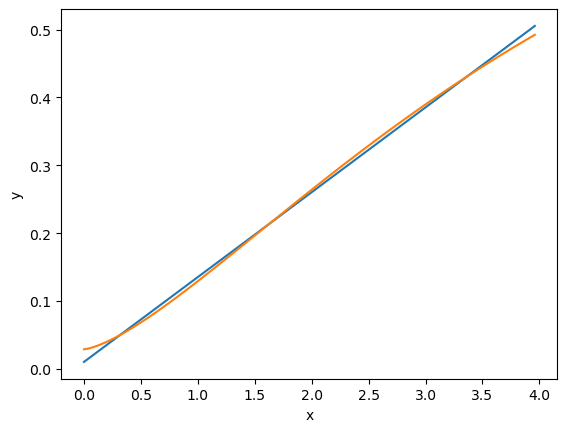

In [22]:
df_5_lin = pred_trace(trace_5_lin)

sns.lineplot(x=x,y=y)
sns.lineplot(x='x',y='y',data=df_5_lin)

In [23]:
df_5_lin.head(1)

,a,b,c,d,g,x,y
0,0.029,1.422,6.562,0.992,1.652,0.0,0.029


### Single subject linear no noise

While the curve fit the data the lack of noise make the fitting not so good.</br>
Lets add some noise to really test the model

## Single subject linear rating with noise

<AxesSubplot:xlabel='x', ylabel='y'>

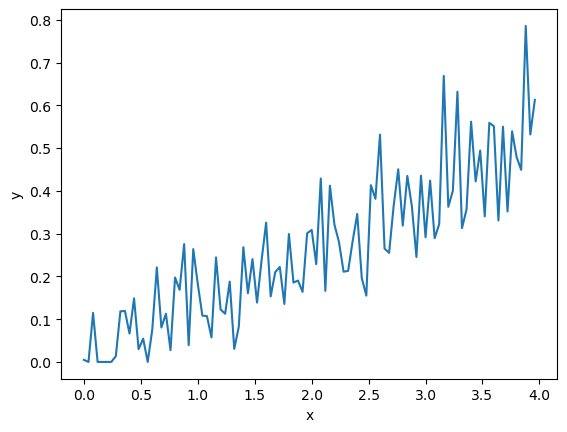

In [24]:
y = x/8 + np.random.normal(0, .1, len(x))
y = [0 if i < 0 else i for i in y]  
df = pd.DataFrame({'x':x, 'y':y})

sns.lineplot(x='x',y='y',data=df)

In [25]:
trace_5_lin_n = pl5_single(df)
trace_5_lin_n.to_netcdf("traces/trace_5_lin_n.nc")

Compiling...
Compilation time =  0:00:04.762150
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:18.388349
Transforming variables...
Transformation time =  0:00:00.033351
Computing Log Likelihood...
Log Likelihood time =  0:00:00.290336


'traces/trace_5_lin_n.nc'

In [26]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    trace_l_n =  jx.sample_numpyro_nuts(tune = 3000, draws = 1000, target_accept=0.95)

Compiling...
Compilation time =  0:00:01.114594
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:03.297893
Transforming variables...
Transformation time =  0:00:00.007352
Computing Log Likelihood...
Log Likelihood time =  0:00:00.113354


In [27]:
comp = az.compare({'Linear model': trace_l_n, '5PL model':trace_5_lin_n}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Linear model,0,95.965516,3.260260,0.000000,1.000000e+00,7.648919,0.000000,False,log
5PL model,1,93.215251,4.221053,2.750265,8.881784e-16,7.638798,1.276525,False,log


<AxesSubplot:xlabel='x', ylabel='y'>

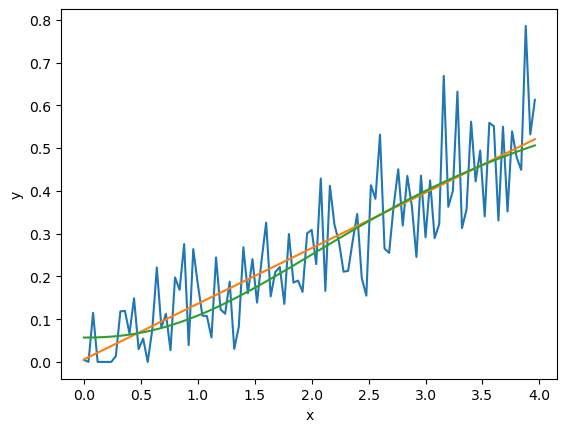

In [28]:
al = az.summary(trace_l_n, var_names=['a'])[['mean']]
bl = az.summary(trace_l_n, var_names=['b'])[['mean']]

df_l_n = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l_n['y'] = df_l_n.a + df_l_n.b * df_l_n.x

df_5_lin_n = pred_trace(trace_5_lin_n)

sns.lineplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y',data=df_l_n)
sns.lineplot(x='x',y='y',data=df_5_lin_n)


### Single subject linear responmse with noise

Expectdly, the linear model fits better, but not by much.</br>
While the fit looks good, the model performance is not that good. </br>
I tried some reparametrization, it reduced the number of divergencies but still not the best.

## Multi subject analysis

Let's see how the model can fit to 10 participant with some noise (.05)


<AxesSubplot:xlabel='x', ylabel='y'>

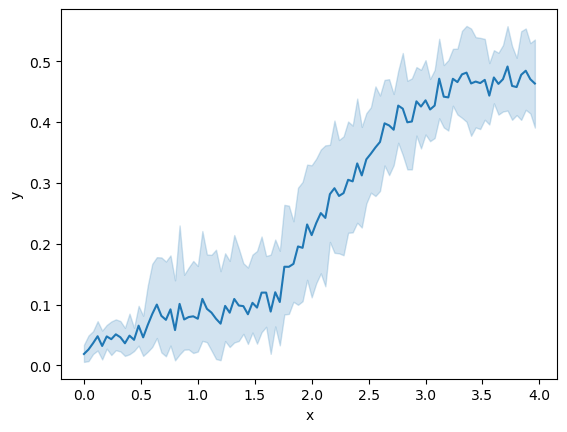

In [29]:
n_subs = 10
df = pd.DataFrame()
for i in range(n_subs):
    
    temp = add_sub(noise = .05)
    temp['sub'] = i
    df = pd.concat([df, temp])
    
sub_idx = list(df['sub'])

sns.lineplot(x='x',y='y',data=df)

In [30]:
trace_PL5_MS = pl5_multi(df, sub_idx, n_subs)
trace_PL5_MS.to_netcdf("traces/trace_PL5_MS.nc")

Compiling...
Compilation time =  0:00:10.851808
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:02:42.914846
Transforming variables...
Transformation time =  0:00:00.114566
Computing Log Likelihood...
Log Likelihood time =  0:00:01.118377


'traces/trace_PL5_MS.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

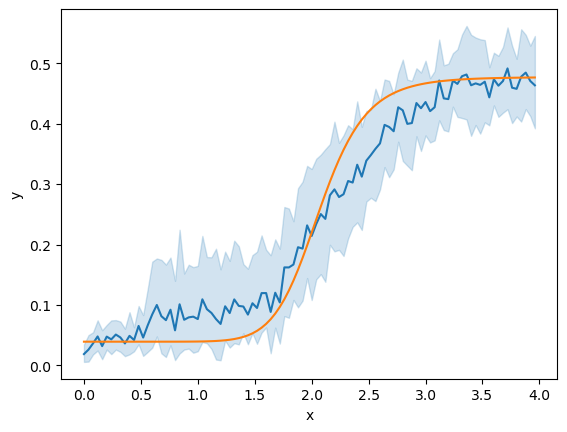

In [31]:
df_5_ms = pred_trace(trace_PL5_MS, single=False)

sns.lineplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y',data=df_5_ms)

### Multi subject analysis

Fit looks good, all measures are with in the expected range.</br>
Can the model handle more people?

## Multi subject larger N

<AxesSubplot:xlabel='x', ylabel='y'>

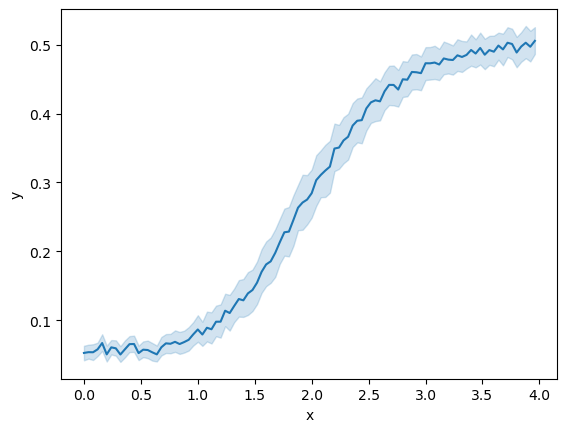

In [32]:
n_subs = 100
df = pd.DataFrame()
for i in range(n_subs):
    
    temp = add_sub(noise = .05)
    temp['sub'] = i
    df = pd.concat([df, temp])
    
sub_idx = list(df['sub'])

sns.lineplot(x='x',y='y',data=df)

In [33]:
trace_PL5_MS2 = pl5_multi(df, sub_idx, n_subs)
trace_PL5_MS2.to_netcdf("traces/trace_PL5_MS2.nc")

Compiling...
Compilation time =  0:00:05.930596
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:27:41.669928
Transforming variables...
Transformation time =  0:00:00.136587
Computing Log Likelihood...
Log Likelihood time =  0:00:04.028359


'traces/trace_PL5_MS2.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

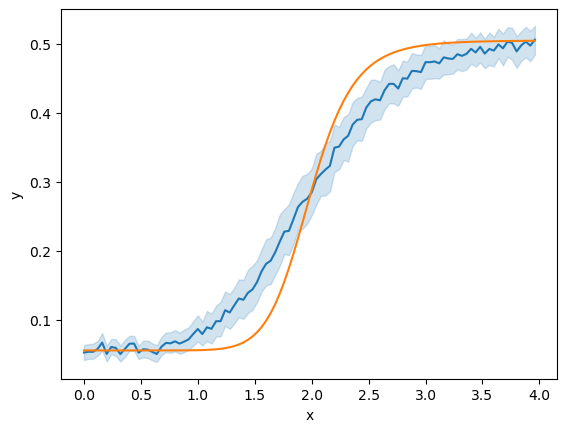

In [34]:
df_5_ms = pred_trace(trace_PL5_MS2, single=False)

sns.lineplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y',data=df_5_ms)

### Multi subjects larger N

First the running time increase proportionally. This might be problematic with actual data.</br>  
We can see that at certain points the fit is outside the CI.</br>


## Two groups analysis

We will begin with a relatively large difference in the slope (6 for control, 10 for PTSD)

<AxesSubplot:xlabel='x', ylabel='y'>

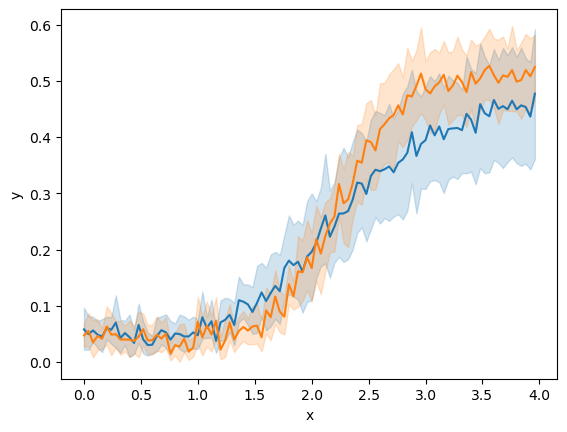

In [35]:
n_subs = 10
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .05, slope = 6)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
    temp_p = add_sub(noise = .05)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

First we will analyze them seperatly.

In [36]:
trace_5pl_c = pl5_multi(cont_df, sub_idxC, n_subs)
trace_5pl_p = pl5_multi(ptsd_df, sub_idxP, n_subs)

trace_5pl_c.to_netcdf("traces/trace_5pl_c.nc")
trace_5pl_p.to_netcdf("traces/trace_5pl_p.nc")

Compiling...
Compilation time =  0:00:05.740488
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:04:58.430002
Transforming variables...
Transformation time =  0:00:00.035708
Computing Log Likelihood...
Log Likelihood time =  0:00:00.649904
Compiling...
Compilation time =  0:00:05.728675
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:02:36.935481
Transforming variables...
Transformation time =  0:00:00.035260
Computing Log Likelihood...
Log Likelihood time =  0:00:00.599838


'traces/trace_5pl_p.nc'

<AxesSubplot:xlabel='x', ylabel='y'>

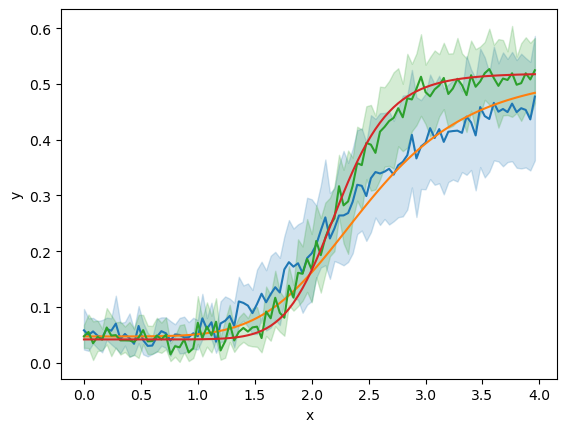

In [37]:
df_c = pred_trace(trace_5pl_c, single=False)
df_p = pred_trace(trace_5pl_p, single=False)

sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=df_c)
sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_p)

<AxesSubplot:ylabel='Count'>

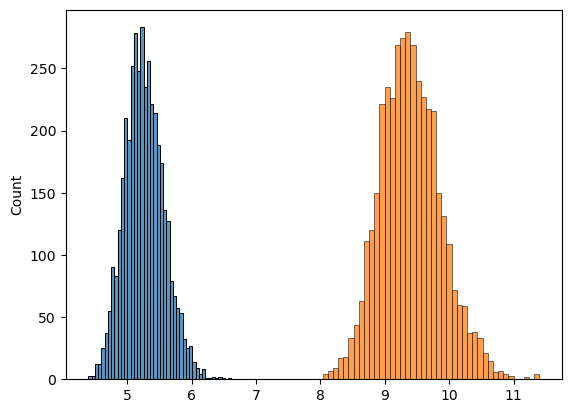

In [38]:
trc = trace_5pl_c.posterior.stack(draws=("chain", "draw"))
trp = trace_5pl_p.posterior.stack(draws=("chain", "draw"))


Control = np.mean(trc.b[:,:].values, axis = 0)
PTSD    = np.mean(trp.b[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

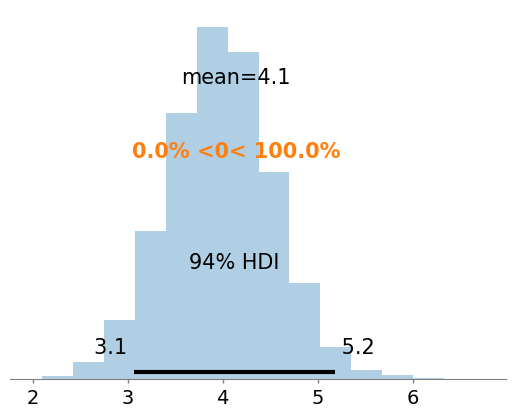

In [39]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

Using two different models, we were able to find the difference within the 94% HDI. </br>
Both models preform well.</br>
Can we create a single model that acheive the same results?

In [40]:
trace_5pl_groups = pl5_multi_groups(df1 = cont_df, df2 = ptsd_df, idx1 = sub_idxC, idx2 = sub_idxP, n_subs1 = n_subs)
trace_5pl_groups.to_netcdf("traces/trace_5pl_groups.nc")

Compiling...
Compilation time =  0:00:19.831478
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:10:14.728088
Transforming variables...
Transformation time =  0:00:00.123366
Computing Log Likelihood...
Log Likelihood time =  0:00:01.224299


'traces/trace_5pl_groups.nc'

<AxesSubplot:ylabel='Count'>

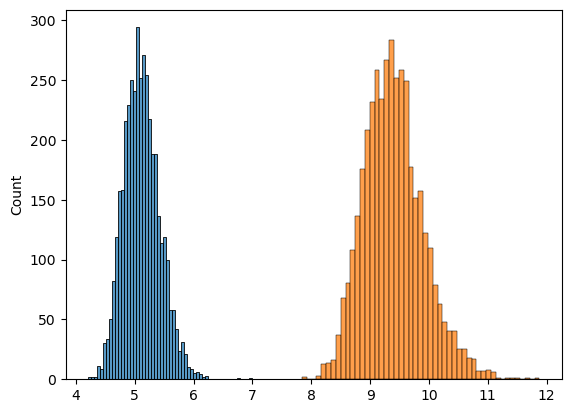

In [41]:
tr = trace_5pl_groups.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.b_1[:,:].values, axis = 0)
PTSD    = np.mean(tr.b_2[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

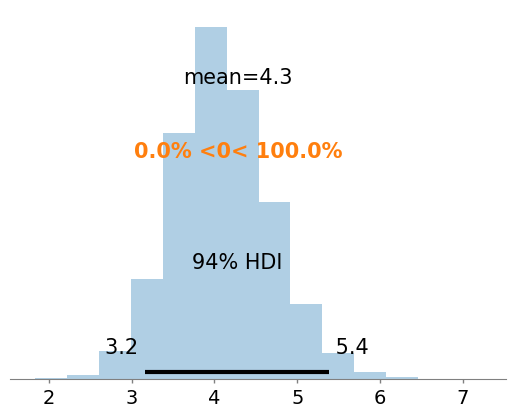

In [42]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

The combine model behaves the same, some divergencies but not too many.

<AxesSubplot:xlabel='x', ylabel='y'>

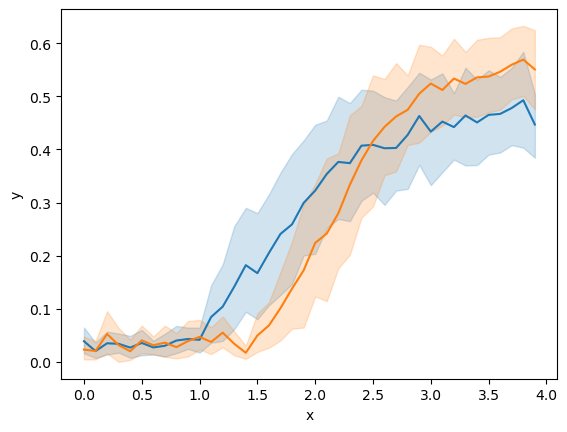

In [43]:
n_subs = 10
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .05, slope = 6, trials = 40)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
    temp_p = add_sub(noise = .05, trials = 40)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [44]:
trace_5pl_groups_40t = pl5_multi_groups(df1 = cont_df, df2 = ptsd_df, idx1 = sub_idxC, idx2 = sub_idxP, n_subs1 = n_subs)
trace_5pl_groups_40t.to_netcdf("traces/trace_5pl_groups_40t.nc")

Compiling...
Compilation time =  0:00:10.647453
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:02:34.598075
Transforming variables...
Transformation time =  0:00:00.058431
Computing Log Likelihood...
Log Likelihood time =  0:00:01.385717


'traces/trace_5pl_groups_40t.nc'

<AxesSubplot:ylabel='Count'>

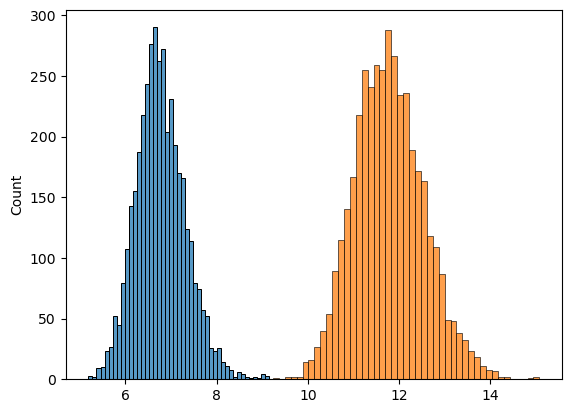

In [45]:
tr = trace_5pl_groups_40t.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.b_1[:,:].values, axis = 0)
PTSD    = np.mean(tr.b_2[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

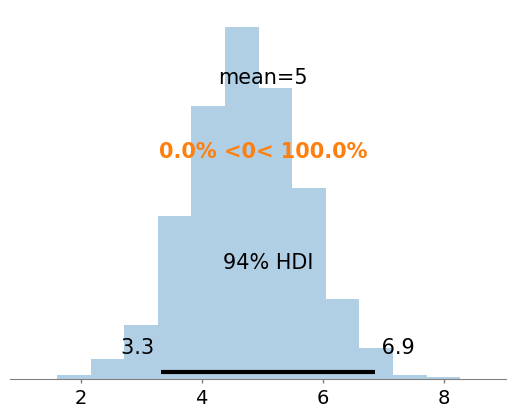

In [46]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

## Uneven groups

How does the model work if there are uneven groups?

/tmp/ipykernel_21564/2063175750.py:13: RuntimeWarning: divide by zero encountered in power
  y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)


<AxesSubplot:xlabel='x', ylabel='y'>

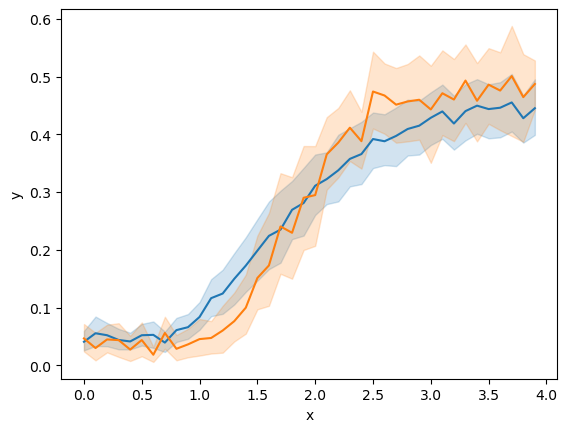

In [47]:
n_subs_c = 30
n_subs_p = 10

cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs_c):
    
    temp_c = add_sub(noise = .05, slope = 6, trials = 40)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
for i in range(n_subs_p):
    
    temp_p = add_sub(noise = .05, trials = 40)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [ ]:
trace_5pl_ue_groups = pl5_multi_groups(df1 = cont_df, df2 = ptsd_df, idx1 = sub_idxC, idx2 = sub_idxP, n_subs1 = n_subs_c, n_subs2=n_subs_p)
trace_5pl_ue_groups.to_netcdf("traces/trace_5pl_ue_groups.nc")

Compiling...
Compilation time =  0:00:11.096900
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
tr = trace_5pl_groups.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.b_1[:,:].values, axis = 0)
PTSD    = np.mean(tr.b_2[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

In [ ]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

The model works!

## 1 group linear

While it will be very easy to distingish between linear and 5PL data. </br>
But will the model work?

In [ ]:
n_subs_c = 30
n_subs_p = 10

cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

x_1 = add_sub(trials = 40, axis=True)

for i in range(n_subs_c):
    
    y = x_1/8 + np.random.normal(0, .05, len(x_1))
    y = [0 if i < 0 else i for i in y]  
    temp_c = pd.DataFrame({'x':x_1, 'y':y})
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
for i in range(n_subs_p):
    
    temp_p = add_sub(noise = .05, slope = 6, trials = 40)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [ ]:
trace_5pl_groups_li = pl5_multi_groups(df1 = cont_df, df2 = ptsd_df, idx1 = sub_idxC, idx2 = sub_idxP, n_subs1 = n_subs_c, n_subs2=n_subs_p)
trace_5pl_groups_li.to_netcdf("traces/trace_5pl_groups_li.nc")

In [ ]:
tr = trace_5pl_groups_li.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.b_1[:,:].values, axis = 0)
PTSD    = np.mean(tr.b_2[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

while the model was able to distingish the data, it is filled with divergencies. 